In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [71]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [72]:
def load_data(file):
    df = pd.read_csv(file)
    df.drop(columns="Unnamed: 0", inplace= True)
    df = df.set_index("Date")
    return df

In [5]:
locA = load_data("data/LocationA.csv")
locB = load_data("data/LocationB.csv")
locC = load_data("data/LocationC.csv")
locD = load_data("data/LocationD.csv")

In [6]:
locA.head()

,TempA,pHA,ECA,DOA,BODA,TNA
Date,,,,,,
12/15/2021,21.50,7.73,1748,2.55,27.96,1.28
12/16/2021,21.21,7.82,1765,2.60,27.90,1.08
12/17/2021,21.21,7.73,1769,2.59,27.88,1.17
12/18/2021,21.26,7.82,1776,2.63,27.66,1.15
12/19/2021,21.09,7.76,1822,2.60,27.71,1.22


<AxesSubplot:xlabel='Date'>

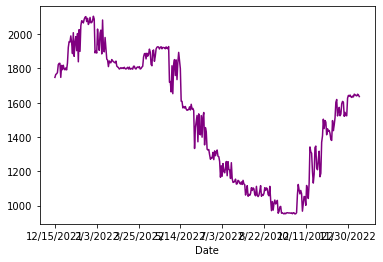

In [7]:
locA["ECA"].plot(color = "purple")

<AxesSubplot:xlabel='Date'>

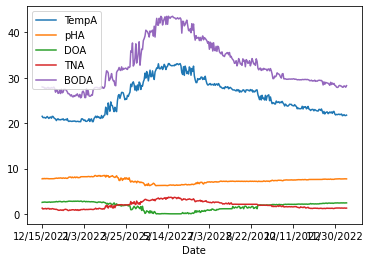

In [8]:
locA[["TempA", "pHA", "DOA", "TNA", "BODA"]].plot()

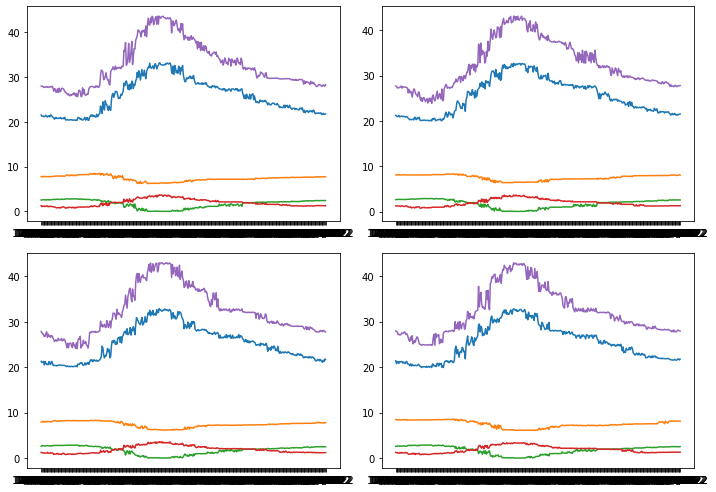

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10,7))
fig.tight_layout()

#create subplots
ax[0, 0].plot(locA[["TempA", "pHA", "DOA", "TNA", "BODA"]])
ax[0, 1].plot(locB[["TempB", "pHB", "DOB", "TNB", "BODB"]])
ax[1, 0].plot(locC[["TempC", "pHC", "DOC", "TNC", "BODC"]])
ax[1, 1].plot(locD[["TempD", "pHD", "DOD", "TND", "BODD"]])

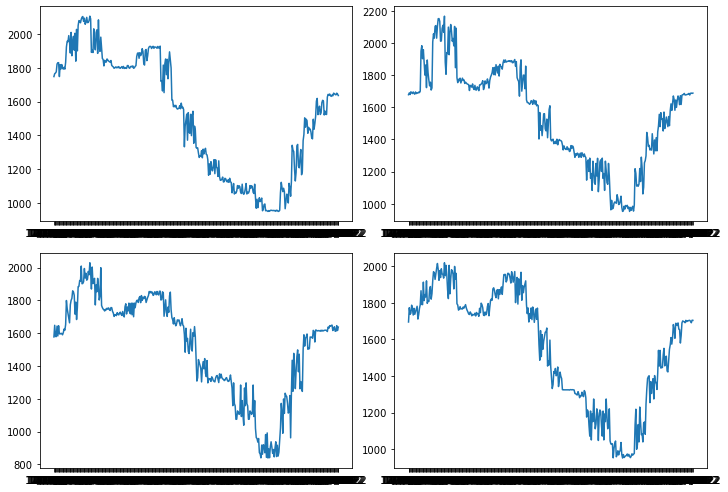

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10,7))
fig.tight_layout()

#create subplots
ax[0, 0].plot(locA["ECA"])
ax[0, 1].plot(locB["ECB"])
ax[1, 0].plot(locC["ECC"])
ax[1, 1].plot(locD["ECD"])

In [7]:
doA = locA["DOA"]
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(doA, WINDOW_SIZE)
X1.shape, y1.shape

((362, 3, 1), (362,))

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

## LSTM

In [19]:
model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-10-22 22:21:52.051592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-22 22:21:52.051640: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-22 22:21:52.051669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-10-22 22:21:52.051980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [21]:
cp1 = ModelCheckpoint('lstmmodel1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[cp1])

In [23]:
model1 = load_model('lstmmodel1/')

In [24]:
train_predictions = model1.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
train_results

8/8 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,0.176350,0.01
1,2.157978,2.17
2,1.796982,0.94
3,1.482837,1.42
4,2.055072,2.09
...,...,...
226,2.407367,2.45
227,2.347026,2.40
228,0.309499,0.07
229,2.051253,2.04


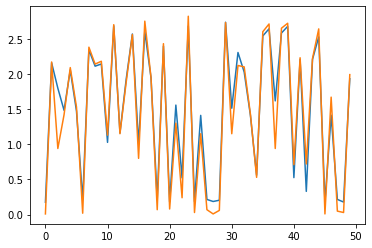

In [25]:
plt.plot(train_results['Train Predictions'][:50])
plt.plot(train_results['Actuals'][:50])

In [73]:
def plot_val(model,Nsample):
    val_predictions = model.predict(x_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
    plt.plot(val_results['Val Predictions'][:Nsample])
    plt.plot(val_results['Actuals'][:Nsample])

In [27]:
val_predictions = model1.predict(x_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

2/2 [==============================] - 0s 3ms/step


,Val Predictions,Actuals
0,0.912046,0.81
1,2.576581,2.56
2,0.737677,0.92
3,0.695246,0.78
4,2.348046,2.43
5,2.297426,2.02
6,2.124618,2.11
7,0.989401,0.94
8,1.470530,1.51
9,2.098287,2.00


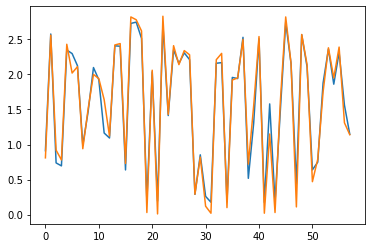

In [28]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [74]:
def plot_test(model, Nsample):
    test_predictions = model.predict(x_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
    plt.plot(test_results['Test Predictions'][:Nsample])
    plt.plot(test_results['Actuals'][:Nsample])

In [30]:
test_predictions = model1.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

3/3 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,1.964109,1.96
1,2.120595,2.18
2,1.837681,1.90
3,0.359868,0.40
4,0.236129,0.05
...,...,...
68,2.218651,2.24
69,2.123446,2.14
70,1.147022,1.15
71,2.154301,2.14


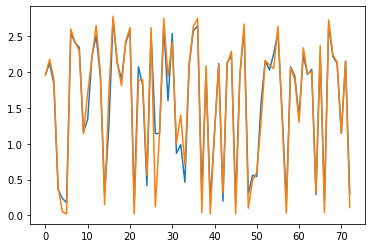

In [31]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [75]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

3/3 [==============================] - 0s 3ms/step


(    Predictions  Actuals
 0      1.964109     1.96
 1      2.120595     2.18
 2      1.837681     1.90
 3      0.359868     0.40
 4      0.236129     0.05
 ..          ...      ...
 68     2.218651     2.24
 69     2.123446     2.14
 70     1.147022     1.15
 71     2.154301     2.14
 72     0.292637     0.11
 
 [73 rows x 2 columns],
 0.03369401638901186)

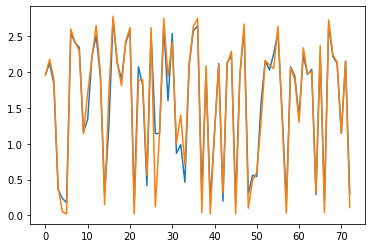

In [33]:
plot_predictions1(model1, x_test, y_test)

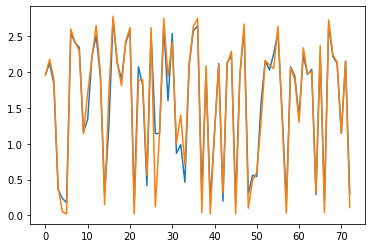

In [36]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

In [48]:
tested_val = model1.predict(x_test)
tested_val.shape

3/3 [==============================] - 0s 2ms/step


(73, 1)

In [52]:
test_predictions.shape

(73,)

In [53]:
y_test.shape

(73,)

## CNN

In [21]:
model2 = Sequential()
model2.add(InputLayer((3, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


2023-11-08 10:59:45.998315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-08 10:59:45.998367: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-08 10:59:45.998400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-11-08 10:59:45.998705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
cp2 = ModelCheckpoint('cnnmodel2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [76]:
def fit_model(model, cp, epochs):
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[cp])
    return model

In [ ]:
model2 = fit_model(model2, cp2, 10)

In [77]:
def plot_train(modelname, Nsample):
    model = load_model(modelname)
    train_predictions = model.predict(x_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
    plt.plot(train_results['Train Predictions'][:Nsample])
    plt.plot(train_results['Actuals'][:Nsample])

8/8 [==============================] - 0s 2ms/step


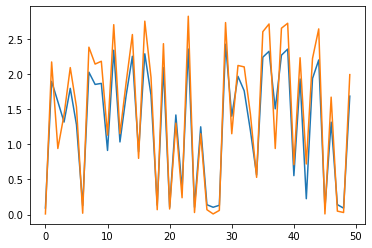

In [74]:
plot_train("cnnmodel2", 50)

2/2 [==============================] - 0s 2ms/step


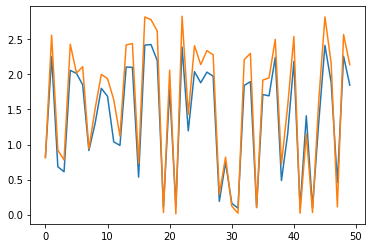

In [75]:
plot_val(model2, 50)

3/3 [==============================] - 0s 3ms/step


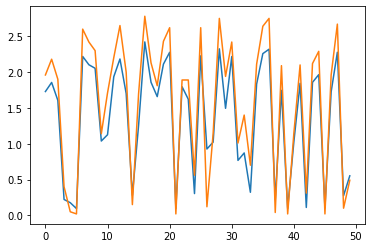

In [76]:
plot_test(model2, 50)

3/3 [==============================] - 0s 4ms/step


(    Predictions  Actuals
 0      1.728765     1.96
 1      1.855364     2.18
 2      1.605830     1.90
 3      0.221747     0.40
 4      0.176536     0.05
 ..          ...      ...
 68     1.962197     2.24
 69     1.847082     2.14
 70     1.022595     1.15
 71     1.878945     2.14
 72     0.182540     0.11
 
 [73 rows x 2 columns],
 0.08708976809397889)

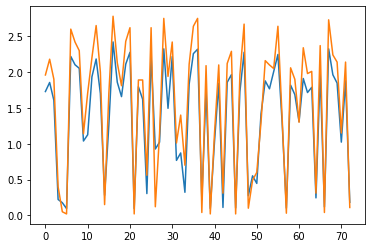

In [77]:
plot_predictions1(model2,x_test, y_test)

## Moving Average 

In [14]:
import numpy as np
import tensorflow as tf

In [39]:
class MovingAverageCNNModel(tf.keras.Model):
    def __init__(self, moving_average_window_size, cnn_architecture):
        super(MovingAverageCNNModel, self).__init__()

        self.moving_average_window_size = moving_average_window_size
        self.cnn_model = cnn_architecture()

    def call(self, inputs):
        moving_average_filtered_inputs = tf.keras.layers.AveragePooling1D(pool_size=self.moving_average_window_size, strides=3)(inputs)

        outputs = self.cnn_model(moving_average_filtered_inputs)

        return outputs


In [ ]:
moving_average_cnn_model = MovingAverageCNNModel(moving_average_window_size=3, cnn_architecture= tf.keras.applications.VGG16)
moving_average_cnn_model.compile(optimizer="adam", loss="mse")
moving_average_cnn_model.fit(x_train, y_train, epochs=100)

## RNN

In [45]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

rnn_model = keras.Sequential([
    layers.SimpleRNN(units=64, input_shape=(3, 1)),
    layers.Dense(units=1)
])

rnn_model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
cp3 = ModelCheckpoint('rnnSimple/', save_best_only=True)

In [ ]:
fit_model(rnn_model, cp3, 100)

8/8 [==============================] - 0s 2ms/step


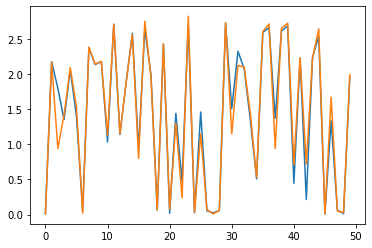

In [50]:
plot_train("rnnSimple/", 50)

3/3 [==============================] - 0s 3ms/step


(    Predictions  Actuals
 0      1.982101     1.96
 1      2.146232     2.18
 2      1.815885     1.90
 3      0.300821     0.40
 4      0.103584     0.05
 ..          ...      ...
 68     2.234959     2.24
 69     2.145051     2.14
 70     1.123829     1.15
 71     2.184371     2.14
 72     0.125367     0.11
 
 [73 rows x 2 columns],
 0.02534982211938762)

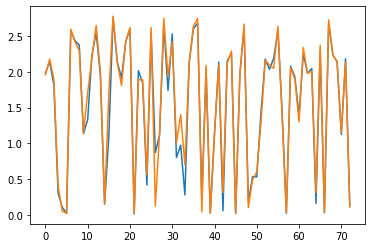

In [69]:
plot_predictions1(rnn_model, x_test,y_test, end = 100)

2/2 [==============================] - 0s 4ms/step


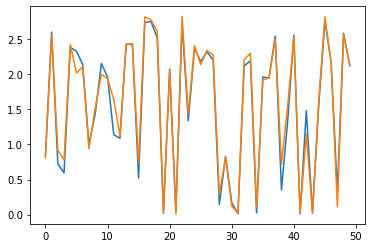

In [55]:
plot_val(rnn_model, 50)

3/3 [==============================] - 0s 3ms/step


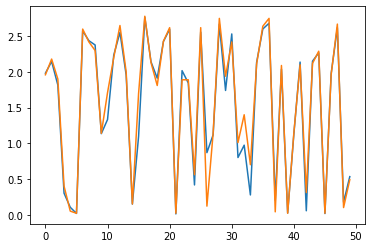

In [57]:
plot_test(rnn_model, 50)

## GRU

In [60]:
gru_model = keras.Sequential([
    layers.GRU(units=64, input_shape=(3, 1)),
    layers.Dense(units=1)
])

gru_model.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
cp4 = ModelCheckpoint('gruSimple/', save_best_only=True)

In [ ]:
fit_model(gru_model, cp4, 100)

8/8 [==============================] - 0s 2ms/step


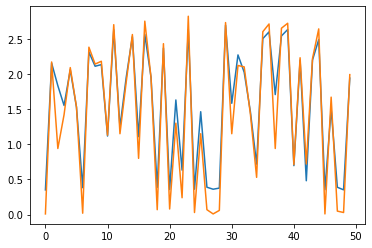

In [66]:
plot_train("gruSimple/", 50)

3/3 [==============================] - 0s 3ms/step


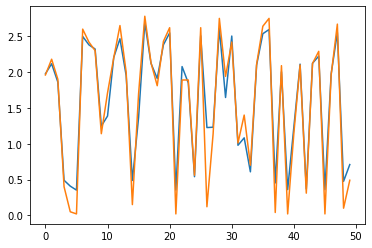

In [67]:
plot_test(gru_model, 50)

3/3 [==============================] - 0s 3ms/step


(    Predictions  Actuals
 0      1.976435     1.96
 1      2.116488     2.18
 2      1.860573     1.90
 3      0.489676     0.40
 4      0.407939     0.05
 ..          ...      ...
 68     2.214649     2.24
 69     2.116177     2.14
 70     1.231942     1.15
 71     2.145133     2.14
 72     0.454163     0.11
 
 [73 rows x 2 columns],
 0.04908100988322617)

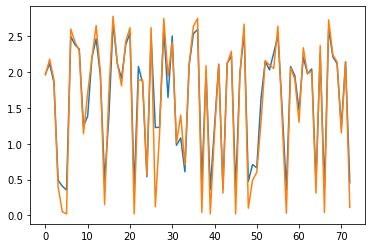

In [68]:
plot_predictions1(gru_model,x_test, y_test, end=100)

2/2 [==============================] - 0s 3ms/step


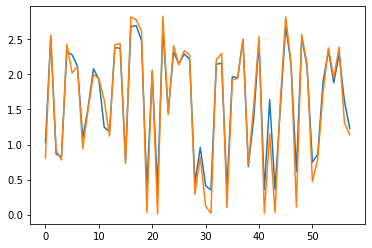

In [70]:
plot_val(gru_model, 100)

In [82]:
gru_model.weights

[<tf.Variable 'gru/gru_cell/kernel:0' shape=(1, 192) dtype=float32, numpy=
 array([[ 0.1678528 , -0.08272997, -0.20014293,  0.0463764 ,  0.16600889,
         -0.00537479,  0.0571119 , -0.04265983, -0.06436626,  0.03169432,
         -0.08734222, -0.04251305,  0.13406937,  0.09694537, -0.16021752,
         -0.01856767,  0.1124074 , -0.01041807, -0.17355311, -0.12287711,
          0.06811762, -0.12642424,  0.04138822, -0.1777327 , -0.1404296 ,
          0.0071273 , -0.08794261, -0.02656213,  0.10432098, -0.01324712,
          0.05021019,  0.1306871 , -0.06034852, -0.13075253,  0.06460406,
          0.00936973, -0.16756156,  0.09186759,  0.03678589, -0.06024969,
         -0.02496909, -0.172166  , -0.0155376 , -0.08356332, -0.07440073,
         -0.09553507,  0.01711256,  0.01031186, -0.04206476,  0.12782858,
          0.02538969, -0.07470998, -0.23186752,  0.00579946,  0.07342917,
          0.01929217, -0.02622273, -0.1137983 ,  0.01075494,  0.12975885,
         -0.0549467 , -0.19758148, -0

In [14]:
import numpy as np
import tensorflow as tf
class MovingAverageCNNModel(tf.keras.Model):
    def __init__(self, moving_average_window_size, cnn_architecture):
        super(MovingAverageCNNModel, self).__init__()

        self.moving_average_window_size = moving_average_window_size
        self.cnn_model = cnn_architecture()

    def call(self, inputs):
        moving_average_filtered_inputs = tf.keras.layers.AveragePooling1D(pool_size=self.moving_average_window_size, strides=1)(inputs)

        outputs = self.cnn_model(moving_average_filtered_inputs)

        return outputs

moving_average_cnn_model = MovingAverageCNNModel(moving_average_window_size=1, cnn_architecture= tf.keras.applications.VGG16)
moving_average_cnn_model.compile(optimizer="adam", loss="mse")


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

locA = pd.read_csv("data/LocationA.csv")
locA = locA.set_index("Date")

doA = locA["DOA"]
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(doA, WINDOW_SIZE)

x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [17]:
x_train.shape

(231, 3, 1)

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, concatenate
import matplotlib.pyplot as plt

# Generate sample data (replace this with your own data loading code)
np.random.seed(42)
data_size = 231
your_time_series_data = x_train.flatten()
target = y_train

# Data preprocessing
window_size = 5
smoothed_data = pd.Series(your_time_series_data.flatten()).rolling(window=window_size).mean().values
smoothed_data = np.expand_dims(np.expand_dims(smoothed_data, axis=-1), axis=-1)  # Reshape to (231, 1, 1)
smoothed_data = smoothed_data.flatten()
# Concatenate smoothed data with original time series data
combined_input = np.concatenate([your_time_series_data, smoothed_data], axis=-2)

# Split the data into training and testing sets
train_size = int(0.8 * data_size)
train_input, test_input = combined_input[:train_size], combined_input[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Build the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(3, 2)))  # 3 features and 2 channels (original + smoothed)
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(combined_input, target, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(test_input, test_target)
print(f'Test Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


AxisError: axis -2 is out of bounds for array of dimension 1

In [39]:
combined_input.shape

(1386,)

In [41]:
target.shape

(231,)

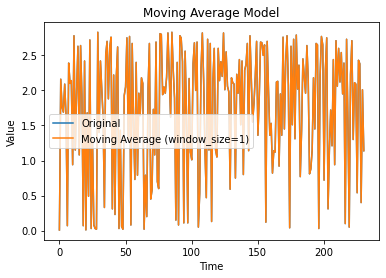

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data (replace this with your own data loading code)
np.random.seed(42)
data_size = 231
your_time_series_data = x_train

# Define a function to calculate the moving average
def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# Apply moving average to each feature separately
window_size = 1
smoothed_data = np.zeros_like(your_time_series_data)

for i in range(your_time_series_data.shape[1]):
    smoothed_data[:, i, :] = moving_average(your_time_series_data[:, i, :], window_size)

# Plot the original and smoothed time series for one feature
feature_index = 0
plt.plot(your_time_series_data[:, feature_index, 0], label='Original')
plt.plot(smoothed_data[:, feature_index, 0], label=f'Moving Average (window_size={window_size})')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Moving Average Model')
plt.show()


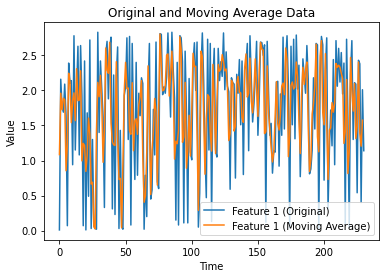

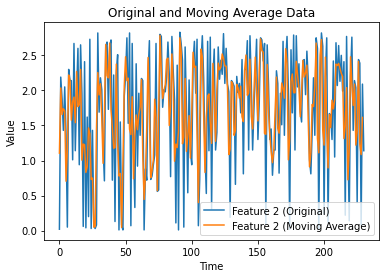

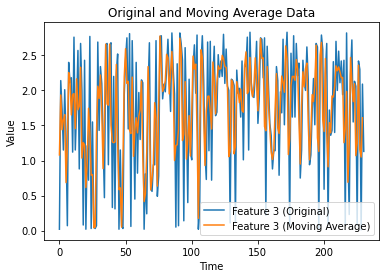

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data (replace this with your own data loading code)
np.random.seed(42)
data_size = 231
your_time_series_data = x_train

# Function to calculate moving average
def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# Apply moving average to each feature separately
window_size = 2
moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=your_time_series_data.squeeze(axis=-1))

# Plot original and moving average data
for i in range(your_time_series_data.shape[1]):
    plt.plot(your_time_series_data[:, i, 0], label=f'Feature {i + 1} (Original)')
    plt.plot(moving_avg_data[:, i], label=f'Feature {i + 1} (Moving Average)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Original and Moving Average Data')
    plt.legend()
    plt.show()

In [58]:
moving_avg_data.shape

(230, 3)

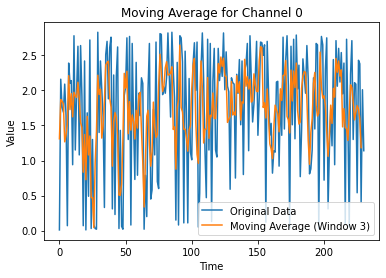

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data (replace this with your own data loading code)
np.random.seed(42)
data_size = 231
your_time_series_data = x_train

# Define the window size for the moving average
window_size = 3

# Calculate the moving average
def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# Apply moving average to each channel separately
moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=your_time_series_data)

# Plot the original and moving average time series for one channel
channel_to_plot = 0  # Choose the channel to plot (0, 1, or 2)
plt.plot(your_time_series_data[:, channel_to_plot, 0], label='Original Data')
plt.plot(moving_avg_data[:, channel_to_plot, 0], label=f'Moving Average (Window {window_size})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Moving Average for Channel {channel_to_plot}')
plt.legend()
plt.show()


In [63]:
moving_avg_data.shape

(230, 3)

In [64]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 3

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=x_train)

In [66]:
moving_avg_data.shape

(229, 3, 1)

In [78]:
model = Sequential()
model.add(InputLayer((3, 1)))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))



cp = ModelCheckpoint('mavg_cnn/', save_best_only=True)
target = y_train[window_size - 1:].flatten()

model = fit_model(model, cp, 10, moving_avg_data, target, x_val, y_val)

TypeError: fit_model() takes 3 positional arguments but 7 were given

In [69]:
plot_train("mavg_cnn", 50, moving_average, target)
plot_val(model, 50, x_val, y_val)
plot_test(model, 50, x_test, y_test)
plot_predictions1(model,x_test, y_test)

NameError: name 'plot_train' is not defined